# 📊 WhatsApp Group Health Analyzer

## What is This Project?
This project analyzes an exported WhatsApp group chat to evaluate group behavior—whether it's healthy or toxic. It utilizes data science techniques like:
- Chat parsing
- Sentiment analysis
- Spam detection
- Data visualization

These insights help understand user behavior, engagement, and overall group health.

## 🤠 Who Is This For?
Ideal for:
- Students learning **Python** or **NLP**
- Data analysts or **ML beginners**
- Anyone curious about **WhatsApp group dynamics**

No prior expertise required! Everything is explained step by step.



## 🔄 Step-by-Step Breakdown

### ✅ Step 1: Get WhatsApp Chat
Export a WhatsApp group chat:
1. **WhatsApp > Group Chat** > Tap **3 dots**
2. Select **More > Export Chat > Without Media**
3. Save the file as `data/sample_chat.txt`


##### Modules used

In [1]:
#! pip install pandas textblob rich matplotlib seaborn
import re
import pandas as pd
from datetime import datetime
from textblob import TextBlob
from rich import print
from rich.table import Table
from rich.console import Console
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
file_path = ".Project/WhatsApp Chat with Sample Group.txt"


In [3]:
def preprocess_chat(file_path):
    pattern = re.compile(r"(\d{2}/\d{2}/\d{4}, \d{2}:\d{2}:\d{2}) - (.*?): (.*)")
    chat_data = []

    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    for line in lines:
        match = pattern.match(line)
        if match:
            date_str, sender, message = match.groups()
            try:
                date_time = datetime.strptime(date_str, "%d/%m/%Y, %H:%M:%S")
                chat_data.append([date_time, sender, message])
            except ValueError:
                continue

    df = pd.DataFrame(chat_data, columns=['datetime', 'sender', 'message'])
    return df

In [4]:
df = preprocess_chat(file_path)
df.head()

,datetime,sender,message
0,2023-01-01 08:02:56,Charlie,Check this out http://spam.com
1,2023-01-01 08:06:22,Alice,I'm happy to hear that!
2,2023-01-01 08:10:55,Bob,Forward this to 10 people!
3,2023-01-01 08:13:48,Bob,Sure.
4,2023-01-01 08:16:08,Bob,This sucks.



### 📚 Step 2: Preprocess the Chat (Text Cleaning)
Using regular expressions, we:
- Extract **timestamp, sender, and message** from each line
- Remove **system messages** (e.g., "You were added")
- Store data in a **structured DataFrame** with three columns:
  ```python
  ['datetime', 'sender', 'message']

In [5]:
def compute_basic_stats(df):
    stats = {
        "total_messages": len(df),
        "messages_per_user": df['sender'].value_counts().to_dict(),
        "most_active_hours": df['datetime'].dt.hour.value_counts().sort_index().to_dict(),
        "emoji_usage_count": int(df['message'].str.count(r'[^\w\s,]').sum()),
        "avg_message_length": round(df['message'].apply(len).mean(), 2)
    }
    return stats

In [6]:
basic_stats = compute_basic_stats(df)
basic_stats

{'total_messages': 10000,
 'messages_per_user': {'Charlie': 2064,
  'Alice': 2037,
  'Eve': 1993,
  'Bob': 1979,
  'Diana': 1927},
 'most_active_hours': {0: 390,
  1: 409,
  2: 411,
  3: 434,
  4: 409,
  5: 412,
  6: 411,
  7: 397,
  8: 423,
  9: 424,
  10: 435,
  11: 422,
  12: 433,
  13: 432,
  14: 430,
  15: 413,
  16: 430,
  17: 436,
  18: 420,
  19: 405,
  20: 401,
  21: 400,
  22: 417,
  23: 406},
 'emoji_usage_count': 15270,
 'avg_message_length': np.float64(12.9)}


### 📊 Step 3: Basic Group Stats
Key statistics include:
- **Total number of messages**
- **Messages sent per user**
- **Active hours (by time of day)**
- **Emoji usage (for fun!)**
- **Average message length**

These indicators highlight overall group activity.



### 😊 Step 4: Sentiment Analysis
Using **TextBlob**, each message receives a sentiment score:
- **Negative** (-1 to 0)
- **Neutral** (0)
- **Positive** (0 to +1)

We then:
- **Visualize sentiment trends** over time
- Apply **rolling average smoothing** for clarity
- **Add threshold lines** to distinguish sentiment boundaries

**Troubleshooting vague graphs:**
- Low number of messages
- Mostly neutral sentiment
- Small rolling window size
- 🔧 **Adjust window size (e.g., window=50) or group data by day** for better smoothing


In [7]:
def analyze_sentiment(df):
    df['sentiment_score'] = df['message'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment_label'] = df['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral')
    )
    return df

In [8]:
sentiment_analysis= analyze_sentiment(df)
sentiment_analysis

,datetime,sender,message,sentiment_score,sentiment_label
0,2023-01-01 08:02:56,Charlie,Check this out http://spam.com,0.0,neutral
1,2023-01-01 08:06:22,Alice,I'm happy to hear that!,1.0,positive
2,2023-01-01 08:10:55,Bob,Forward this to 10 people!,0.0,neutral
3,2023-01-01 08:13:48,Bob,Sure.,0.5,positive
4,2023-01-01 08:16:08,Bob,This sucks.,-0.3,negative
...,...,...,...,...,...
9995,2023-01-19 18:41:44,Charlie,I see.,0.0,neutral
9996,2023-01-19 18:44:05,Eve,Forward this to 10 people!,0.0,neutral
9997,2023-01-19 18:48:11,Bob,Buy now!! http://dealz.com,0.0,neutral
9998,2023-01-19 18:50:27,Charlie,Sure.,0.5,positive



### ⚠️ Step 5: Spam Detection
Spam scoring is based on:
- **Repeated messages**
- **Links (e.g., "http...")**
- **Forwarded content**
Each user's **spam_score** contributes to the group analysis.



In [9]:
def detect_spam(df):
    df['is_link'] = df['message'].str.contains("http", case=False, na=False).astype(int)
    df['is_forwarded'] = df['message'].str.lower().str.contains("forward").astype(int)
    df['is_repeated'] = df.duplicated(subset=['message']).astype(int)
    df['spam_score'] = df[['is_link', 'is_forwarded', 'is_repeated']].sum(axis=1)
    return df

In [10]:
spam_detection=detect_spam(df)
spam_detection

,datetime,sender,message,sentiment_score,sentiment_label,is_link,is_forwarded,is_repeated,spam_score
0,2023-01-01 08:02:56,Charlie,Check this out http://spam.com,0.0,neutral,1,0,0,1
1,2023-01-01 08:06:22,Alice,I'm happy to hear that!,1.0,positive,0,0,0,0
2,2023-01-01 08:10:55,Bob,Forward this to 10 people!,0.0,neutral,0,1,0,1
3,2023-01-01 08:13:48,Bob,Sure.,0.5,positive,0,0,0,0
4,2023-01-01 08:16:08,Bob,This sucks.,-0.3,negative,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,2023-01-19 18:41:44,Charlie,I see.,0.0,neutral,0,0,1,1
9996,2023-01-19 18:44:05,Eve,Forward this to 10 people!,0.0,neutral,0,1,1,2
9997,2023-01-19 18:48:11,Bob,Buy now!! http://dealz.com,0.0,neutral,1,0,1,2
9998,2023-01-19 18:50:27,Charlie,Sure.,0.5,positive,0,0,1,1


### 🧬 Step 6: Group Health Score
The overall score (0-100) is determined by:
- **Positivity Score** ➔ Based on sentiment (Neutral = 50, Positive = closer to 100)
- **Activity Balance** ➔ Even participation improves health
- **Spam Penalty** ➔ Points deducted for excessive spam

The score is clipped between **0–100** to prevent extreme values.



In [11]:
def calculate_group_health(df):
    messages_per_user = df['sender'].value_counts()
    positivity_score = df['sentiment_score'].mean() * 50 + 50
    activity_balance = 100 - messages_per_user.std()
    spam_penalty = df['spam_score'].sum() * 0.01
    health_score = max(0, min(100, positivity_score + activity_balance - spam_penalty))

    spam_score_per_user = df.groupby('sender')['spam_score'].sum().to_dict()

    return {
        "positivity_score": round(positivity_score, 2),
        "activity_balance": round(activity_balance, 2),
        "spam_penalty": round(spam_penalty, 2),
        "final_health_score": round(health_score, 2),
        "spam_score_per_user": spam_score_per_user
    }

In [12]:
health_report=calculate_group_health(spam_detection)
health_report

{'positivity_score': np.float64(60.81),
 'activity_balance': np.float64(46.89),
 'spam_penalty': np.float64(113.69),
 'final_health_score': 0,
 'spam_score_per_user': {'Alice': 2310,
  'Bob': 2284,
  'Charlie': 2336,
  'Diana': 2195,
  'Eve': 2244}}

### 📏 When Health Score is 0
A **score of 0** usually means:
- **Negative sentiment dominates** the conversation
- **Major activity imbalance** (few users dominate)
- **Excessive spam** (many links, forwards, or repeated messages)

The formula penalizes these behaviors, reducing health accordingly.

### 🌐 Step 7: Data Visualization
Saved graphs include:
- **Messages per user** (bar chart)
- **Activity by hour** (bar chart)
- **Sentiment trend over time** (line chart with rolling average)

These visualizations provide insights into group dynamics.

---

This markdown format improves readability and organization while keeping all important details intact! Let me know if you need any refinements. 🚀

In [13]:
def display_stats(title, stats_dict, emoji="📊"):
    table = Table(title=f"{emoji} {title}", title_style="bold magenta")
    table.add_column("Metric", style="cyan", no_wrap=True)
    table.add_column("Value", style="green")
    for k, v in stats_dict.items():
        table.add_row(str(k), str(v))
    print(table)

In [14]:
display_stats("Basic Chat Statistics", basic_stats, emoji="📈")
display_stats("Group Health Report", health_report, emoji="🧠")


                                             📈 Basic Chat Statistics                                              
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ total_messages     │ 10000                                                                                      │
│ messages_per_user  │ {'Charlie': 2064, 'Alice': 2037, 'Eve': 1993, 'Bob': 1979, 'Diana': 1927}                  │
│ most_active_hours  │ {0: 390, 1: 409, 2: 411, 3: 434, 4: 409, 5: 412, 6: 411, 7: 397, 8: 423, 9: 424, 10: 435,  │
│                    │ 11: 422, 12: 433, 13: 432, 14: 430, 15: 413, 16: 430, 17: 436, 18: 420, 19: 405, 20: 401,  │
│                    │ 21: 400, 22: 417, 23: 406}                                                                 │
│ emoji_usage_count  │ 15270                                                                                      │
│ avg_message_length │ 12.9                                                                                       │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────┘

                                      🧠 Group Health Report                                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric              ┃ Value                                                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ positivity_score    │ 60.81                                                                     │
│ activity_balance    │ 46.89                                                                     │
│ spam_penalty        │ 113.69                                                                    │
│ final_health_score  │ 0                                                                         │
│ spam_score_per_user │ {'Alice': 2310, 'Bob': 2284, 'Charlie': 2336, 'Diana': 2195, 'Eve': 2244} │
└─────────────────────┴───────────────────────────────────────────────────────────────────────────┘

In [15]:
def generate_graphs(df):
    # Messages per user
    plt.figure(figsize=(10, 5))
    df['sender'].value_counts().plot(kind='bar', color='skyblue')
    plt.title("Messages per User")
    plt.xlabel("User")
    plt.ylabel("Messages")
    plt.tight_layout()
    plt.show()

    # Messages by hour
    plt.figure(figsize=(10, 5))
    df['datetime'].dt.hour.value_counts().sort_index().plot(kind='bar', color='salmon')
    plt.title("Activity by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Messages")
    plt.tight_layout()
    plt.show()

    # Sentiment trend with clearer bands
    df_sorted = df.sort_values("datetime")
    df_sorted['rolling_sentiment'] = df_sorted['sentiment_score'].rolling(window=50, min_periods=1).mean()

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_sorted, x='datetime', y='rolling_sentiment', label="Sentiment Trend", color="purple")
    plt.axhline(y=0.1, color='green', linestyle='--', label='Positive Threshold')
    plt.axhline(y=-0.1, color='red', linestyle='--', label='Negative Threshold')
    plt.title("📈 Sentiment Trend Over Time (Smoothed)")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

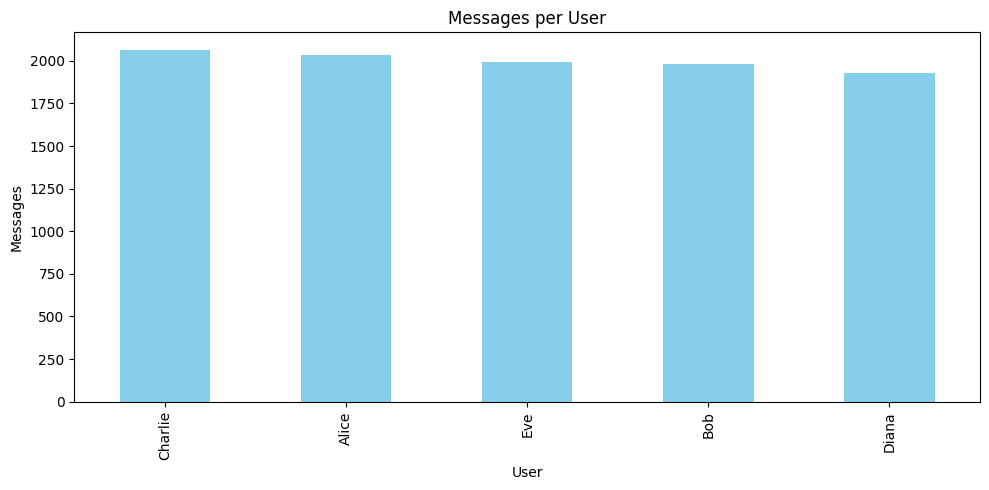

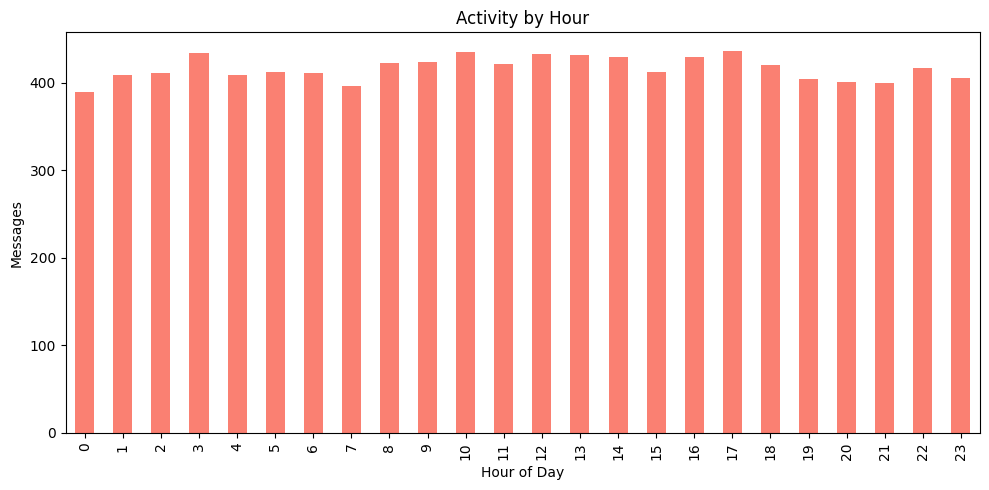

C:\Users\Mridul Gupta\AppData\Local\Temp\ipykernel_8080\3246252329.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Anaconda\envs\Data_Science_with_Python\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


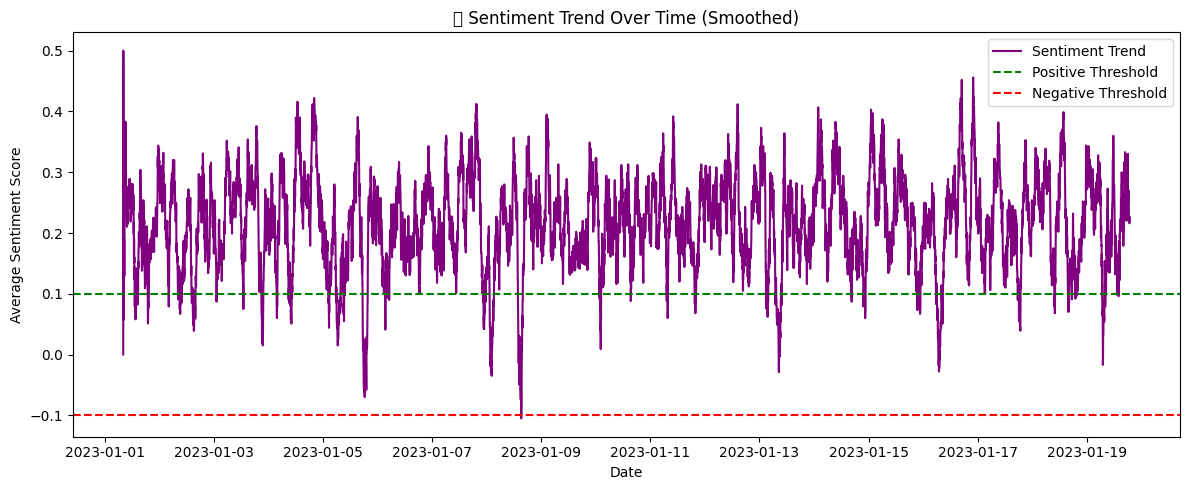

In [16]:
generate_graphs(spam_detection)

## 📈 Understanding the Sentiment Trend Graph

The **Sentiment Trend Over Time** graph is a smoothed line chart that shows how the emotional tone of the group chat changes over time.

### 📌 What the Graph Represents:

- The **X-axis** represents the timeline (from earliest to latest messages).
- The **Y-axis** shows the **average sentiment score** (rolling average).
- Each point on the curve reflects the sentiment of recent messages (smoothed using a moving average).



### 🎯 Positive and Negative Thresholds

We include two dashed horizontal lines to make it easier to interpret the sentiment:

- **Green Line (Positive Threshold)** at **+0.1**:  
  If the rolling sentiment score is **above this**, the group chat is considered to be **overall positive or supportive**.

- **Red Line (Negative Threshold)** at **–0.1**:  
  If the score **drops below this**, the chat is likely becoming **toxic, negative, or argumentative**.

Anything between -0.1 and +0.1 is considered **neutral**.



### 📊 What is Average Sentiment Score?

Sentiment score is computed using TextBlob, which returns a value between **-1.0 (very negative)** to **+1.0 (very positive)** for each message.

- A score around `0.0` is neutral.
- A **rolling average** smooths sudden spikes, making trends more visible.
- The graph helps identify periods of:
  - 🔥 **Toxicity** (when the trend dips)
  - 🫂 **Supportiveness** (when it rises)



### ✅ What Does YOUR Graph Show?

- The sentiment mostly fluctuates **above 0**, meaning your group has a generally **positive tone**.
- There are **frequent dips**, some close to or below 0, showing **neutral or mildly negative** chats.
- **Very few points go below –0.1**, which means **no strong toxicity** is present.
- The line stays mostly **above the green line**, indicating **positive engagement** overall.

This suggests:
- Healthy emotional dynamics.
- Some disagreements (which are natural).
- A **generally respectful and supportive environment**.



### 🔍 Why This Matters?

Tracking sentiment over time helps identify:
- Periods of **high support or conflict**
- Behavior trends in group dynamics
- Whether your group is healthy or needs moderation



In [17]:
df.to_csv(r"C:/Users/Mridul Gupta/Desktop/Project/processed_chat.csv", index=False)